# PET preprocessing+augmentation for the new and improved data pipeline 

Steps involved:
1. Smoothing to remove/minimize PSF reconstruction artifacts, if any.
2. Intensity standardization
3. Data augmentation, including intensity stretching at high SUV levels.
4. Windowing and rescaling.

In [15]:
import os, time

import numpy as np
import scipy.ndimage
import matplotlib.pyplot as plt
import SimpleITK as sitk
from torchio.transforms import HistogramStandardization

import sys
sys.path.append('../')
from data_utils.visualization import NdimageVisualizer, display_image
from data_utils.conversion import *

In [2]:
data_dir = "/home/chinmay/Datasets/HECKTOR/hecktor_train/crFH_rs113_hecktor_nii"
sample_patient_id = "CHGJ007"
PET_sitk = sitk.ReadImage(f"{data_dir}/{sample_patient_id}_pt.nii.gz") # Shape (W,H,D): 450x450x90 voxels

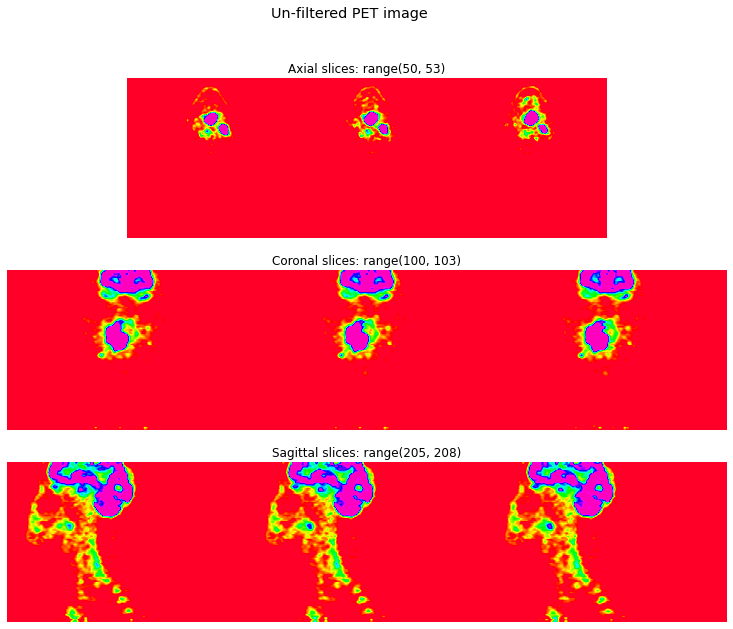

In [3]:
display_image(PET_sitk,
               axial_idxs=range(50,53),
               coronal_idxs=range(100,103),
               sagittal_idxs=range(205,208),
               window={'level':3, 'width':5},
               title="Un-filtered PET image", cmap='gist_rainbow')

## 1 Smoothing

In [4]:
PET_np = sitk2np(PET_sitk, keep_whd_ordering=True)

t1 = time.time()
sigma = [2.0, 2.0, 2.0/3] # In format (W,H,D), Physical sigma of 2mm adjusted according to voxel spacing
PET_smooth_np = scipy.ndimage.gaussian_filter(PET_np, sigma=sigma)
time_diff = time.time() - t1

print(f"Time taken for filtering: {time_diff:.2f}s")

Time taken for filtering: 0.78s


## 2 Standardizing the Intensities

In [5]:
PET_std_np = PET_smooth_np.copy()



## 3 Data Augmentation

### 3.1 Intensity stretching

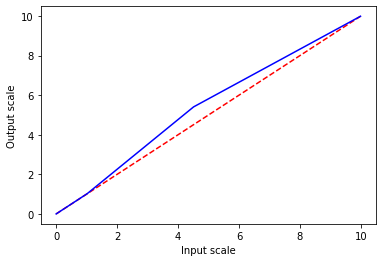

In [6]:
# Conceptual example on dummy data --

input_scale = np.arange(0, 10, 0.01)
output_scale = input_scale.copy()
max_val = max(input_scale)

# Dummy percentile values
p30 = 1
p95 = 4.5

p95_increase_factor = 1.2

# Stretch the contrast in range [p30, p95)
mask = (input_scale>=p30) & (input_scale<p95)
output_scale[mask] = (input_scale[mask]-p30)/(p95-p30) * (p95_increase_factor*p95-p30) + p30

# Squeeze the contrast in range [p95, max]
mask = (input_scale>=p95) & (input_scale<=max_val)
output_scale[mask] = (input_scale[mask]-p95)/(max_val-p95) * (max_val-p95_increase_factor*p95) + p95_increase_factor*p95


plt.plot(input_scale, input_scale, 'r--')
plt.plot(input_scale, output_scale, 'b')
plt.xlabel("Input scale")
plt.ylabel("Output scale")
plt.show()

In [7]:
# Applying to PET -- stretch the contrast in the range between 30 percentile and 95 percentile 

# PET_np = sitk2np(PET_sitk, keep_whd_ordering=True)
p30 = np.percentile(PET_std_np, 30)
p95 = np.percentile(PET_std_np, 95)
max_suv = PET_std_np.max()

print("30 percentile:", p30)
print("95 percentile:", p95)

p95_increase_factor = 1.2

PET_stretched_np = PET_std_np.copy()

# Stretch the contrast in range [p30, p95)
mask = (PET_std_np >= p30) & (PET_std_np < p95)
PET_stretched_np[mask] = (PET_std_np[mask]-p30)/(p95-p30) * (p95_increase_factor*p95-p30) + p30

# Squeeze the contrast in range [p95, max]
mask = (PET_std_np >= p95) & (PET_std_np <= 255)
PET_stretched_np[mask] = (PET_std_np[mask]-p95)/(max_suv-p95) * (max_suv-p95_increase_factor*p95) + p95_increase_factor*p95


30 percentile: 0.001482149469666183
95 percentile: 1.2650858223438264


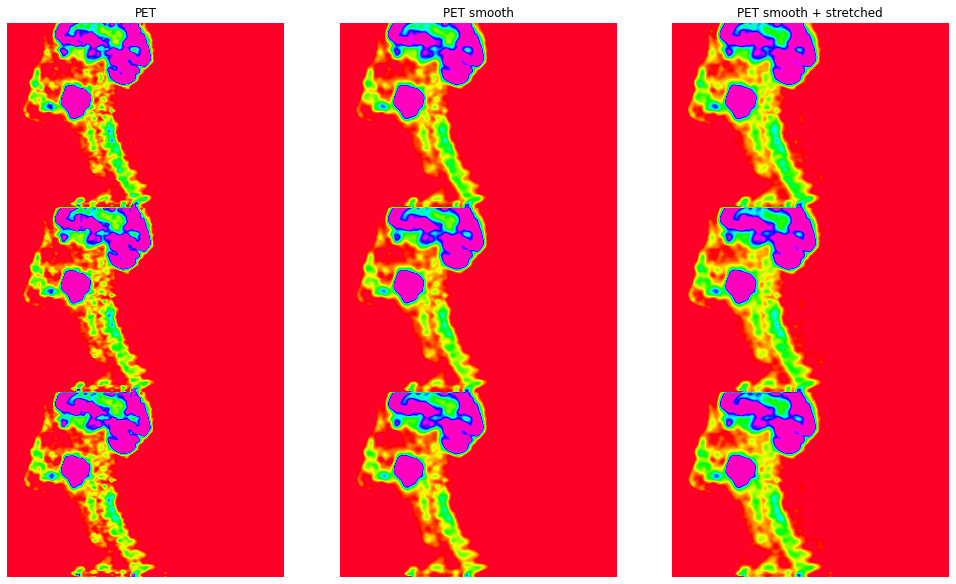

In [9]:
viz = NdimageVisualizer()
viz.multi_image_strips([PET_np, PET_smooth_np, PET_stretched_np],
                          modalities=['PET'] * 3,
                          idx_range=[250, 253],
                          view='sagittal',
                          subtitles=["PET", "PET smooth", "PET smooth + stretched"])

### 3.2 Random rotation

### 3.3 Shear

### 3.4 Elastic distortion